# Scooby Evaluator

## General Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

from scooby.modeling import Scooby
from scooby.data import onTheFlyDataset, onTheFlyPseudobulkDataset
from scooby.utils.utils import fix_rev_comp_rna, undo_squashed_scale, get_pseudobulk_count_pred,get_gene_slice_and_strand

In [3]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data'

## scooby

### Functions for Pearson correlation

In [4]:
def stack_and_pearson(x,y):
    return torch.corrcoef(torch.stack([x,y]))[0,1]
batched_pearson = torch.vmap(stack_and_pearson, chunk_size=1)

def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp_test = fix_rev_comp_rna(flipped_version) #fix_rev_comp2(flipped_version)
    return (outputs + outputs_rev_comp_test)/2

### Load the model

In [5]:
import yaml
with open("../../../scripts/training_onek1k/config_rna_only.yaml", "r") as f:
        config = yaml.safe_load(f)

In [6]:
# Extract configuration parameters
local_world_size = 1
output_dir = config["output_dir"]
run_name = config["run_name"]

rna_plus = config["data"]["rna_plus_path"]
rna_minus = config["data"]["rna_minus_path"]
embedding_path = config["data"]["embedding_path"]
neighbors_path = config["data"]["neighbors_path"]
sequences_path = config["data"]["sequences_path"]
genome_path = config["data"]["genome_path"]

cell_emb_dim = config["model"]["cell_emb_dim"]
num_tracks = config["model"]["num_tracks"]
batch_size = config["training"]["batch_size"]
lr = float(config["training"]["lr"])
wd = float(config["training"]["wd"])
clip_global_norm = config["training"]["clip_global_norm"]
warmup_steps = config["training"]["warmup_steps"] * local_world_size
num_epochs = config["training"]["num_epochs"] * local_world_size
eval_every_n = config["training"]["eval_every_n"]
total_weight = config["training"]["total_weight"]
test_fold = config["data"]["test_fold"]
val_fold = config["data"]["val_fold"]
context_length = config["data"]["context_length"]
shift_augs = config["data"]["shift_augs"]
rc_aug = config["data"]["rc_aug"]

In [7]:
embedding_path

'/s/project/QNA/scborzoi/submission_data/onek1k_training_data/embedding_no_val_genes.pq'

In [8]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Option 2: Load self-trained scooby checkpoint, un-lora it, and save it

In [9]:
import safetensors
from scooby.utils.utils import get_lora

csb = Scooby.from_pretrained(os.path.join(data_path, 'scooby_onek1k/'), 
        cell_emb_dim=10,
    embedding_dim=1920,
    n_tracks=2,
    return_center_bins_only=True,
    disable_cache=False,
    use_transform_borzoi_emb=True
                               )

In [10]:
sum(p.numel() for p in csb.parameters() if p.requires_grad)

191242274

In [11]:
sum(p.numel() for p in csb.parameters())

191242274

### Specify genome

In [12]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")

### Load neighbors and embedding

In [13]:
base_path = os.path.join(data_path, 'onek1k_training_data/pseudobulks')

In [14]:
neighbors = scipy.sparse.load_npz(neighbors_path)
embedding = pd.read_parquet(embedding_path)
embedding['embedding'] = embedding['embedding']

In [15]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'onek1k_training_data/celltype_fixed.pq'))

In [16]:
# cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').str.replace("/", "_")
cell_type_index = cell_type_index.sort_values('celltype')

## Eval on Val

### Sequence dataloader 

This only loads the sequences in the right order

In [17]:
from scooby.utils.transcriptome import Transcriptome

In [18]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [19]:
transcriptome = Transcriptome(gtf_file, use_geneid=True)

In [20]:
context_length  = 524288
clip_soft=5

In [21]:
data_path

'/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data'

In [22]:
import polars as pl
filter_val = lambda df: df.filter(True)#
val_ds = GenomeIntervalDataset(
    bed_file = os.path.join(data_path, 'onek1k_training_data', 'val_gene_sequences.csv'),
    fasta_file = genome_path,
    filter_df_fn = lambda df: df.filter((pl.col('column_2') >=0)), 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

3537

In [23]:
val_dataset = onTheFlyDataset(
    None,
    None,
    neighbors,
    embedding,
    val_ds,
    get_targets= False,
    random_cells = False,
    cells_to_run = None, 
    clip_soft = clip_soft,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
csb, val_loader = accelerator.prepare(csb, val_loader)
clip_soft

5

In [24]:
cell_type_index['celltype'].values

array(['B cell', 'CD16+ monocyte', 'CD4+ CTL cell', 'CD4+ T cell',
       'CD4+ TCM cell', 'CD4+ TEM cell', 'CD56+ NK cell', 'CD8+ T cell',
       'CD8+ TCM cell', 'CD8+ TEM cell', 'MAIT cell', 'NK cell',
       'Treg memory', 'dendritic cell', 'dnT cell', 'gdT cell',
       'hematopoietic precursor cell', 'memory B cell', 'monocyte',
       'plasmablast', 'plasmacytoid dendritic cell', 'platelet'],
      dtype=object)

### Target dataloader on bigwig pseudobulk files

In [25]:
val_dataset_targets = onTheFlyPseudobulkDataset(
    cell_types = cell_type_index['celltype'].values,
    ds = val_ds, 
    base_path = base_path,
)

### Get cell conv_weights for all cells

In [26]:
csb.eval()
cell_indices  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices.append(
        torch.from_numpy(
            np.vstack(
                embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases = []
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = True):
    cell_emb_idx = cell_emb_idx.cuda()
    conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((conv_weights.to(torch.float16), conv_biases.to(torch.float16)))


### Get counts over exons

In [27]:
num_neighbors = 1

all_outputs, all_targets = [], []
val_dataset_target_loader = iter(DataLoader(val_dataset_targets, batch_size=1, shuffle = False, num_workers = 4))

# iterate over all gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):
    gene_slice, strand = get_gene_slice_and_strand(transcriptome, val_dataset_targets.genome_ds.df[i, 'column_4'], val_dataset_targets.genome_ds.df[i, 'column_2'], span = False)
    # continue
    targets = (next(val_dataset_target_loader)[2]).float().cuda()
    if len(gene_slice) == 0:
        continue
    
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    stacked_outputs = []

    stacked_outputs = get_pseudobulk_count_pred(
        csb = csb, 
        seqs = seqs, 
        cell_emb_conv_weights_and_biases = cell_emb_conv_weights_and_biases, 
        gene_slice = gene_slice,
        strand = strand, 
        model_type = "rna",
        predict = predict,  
        clip_soft = clip_soft, 
        num_neighbors = 1,
        chunk_size=70000
    )
    temp_stack = []
    all_outputs.append(stacked_outputs)
    if strand == '+':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, ::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    elif strand == '-':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, 1::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())

100%|██████████| 3537/3537 [31:46<00:00,  1.86it/s]


In [28]:
all_outputs, all_targets = torch.vstack(all_outputs).clone().numpy(force=True),torch.vstack(all_targets).clone().numpy(force=True)

In [29]:
spearmanr = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])
]
pearsonr =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

In [30]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

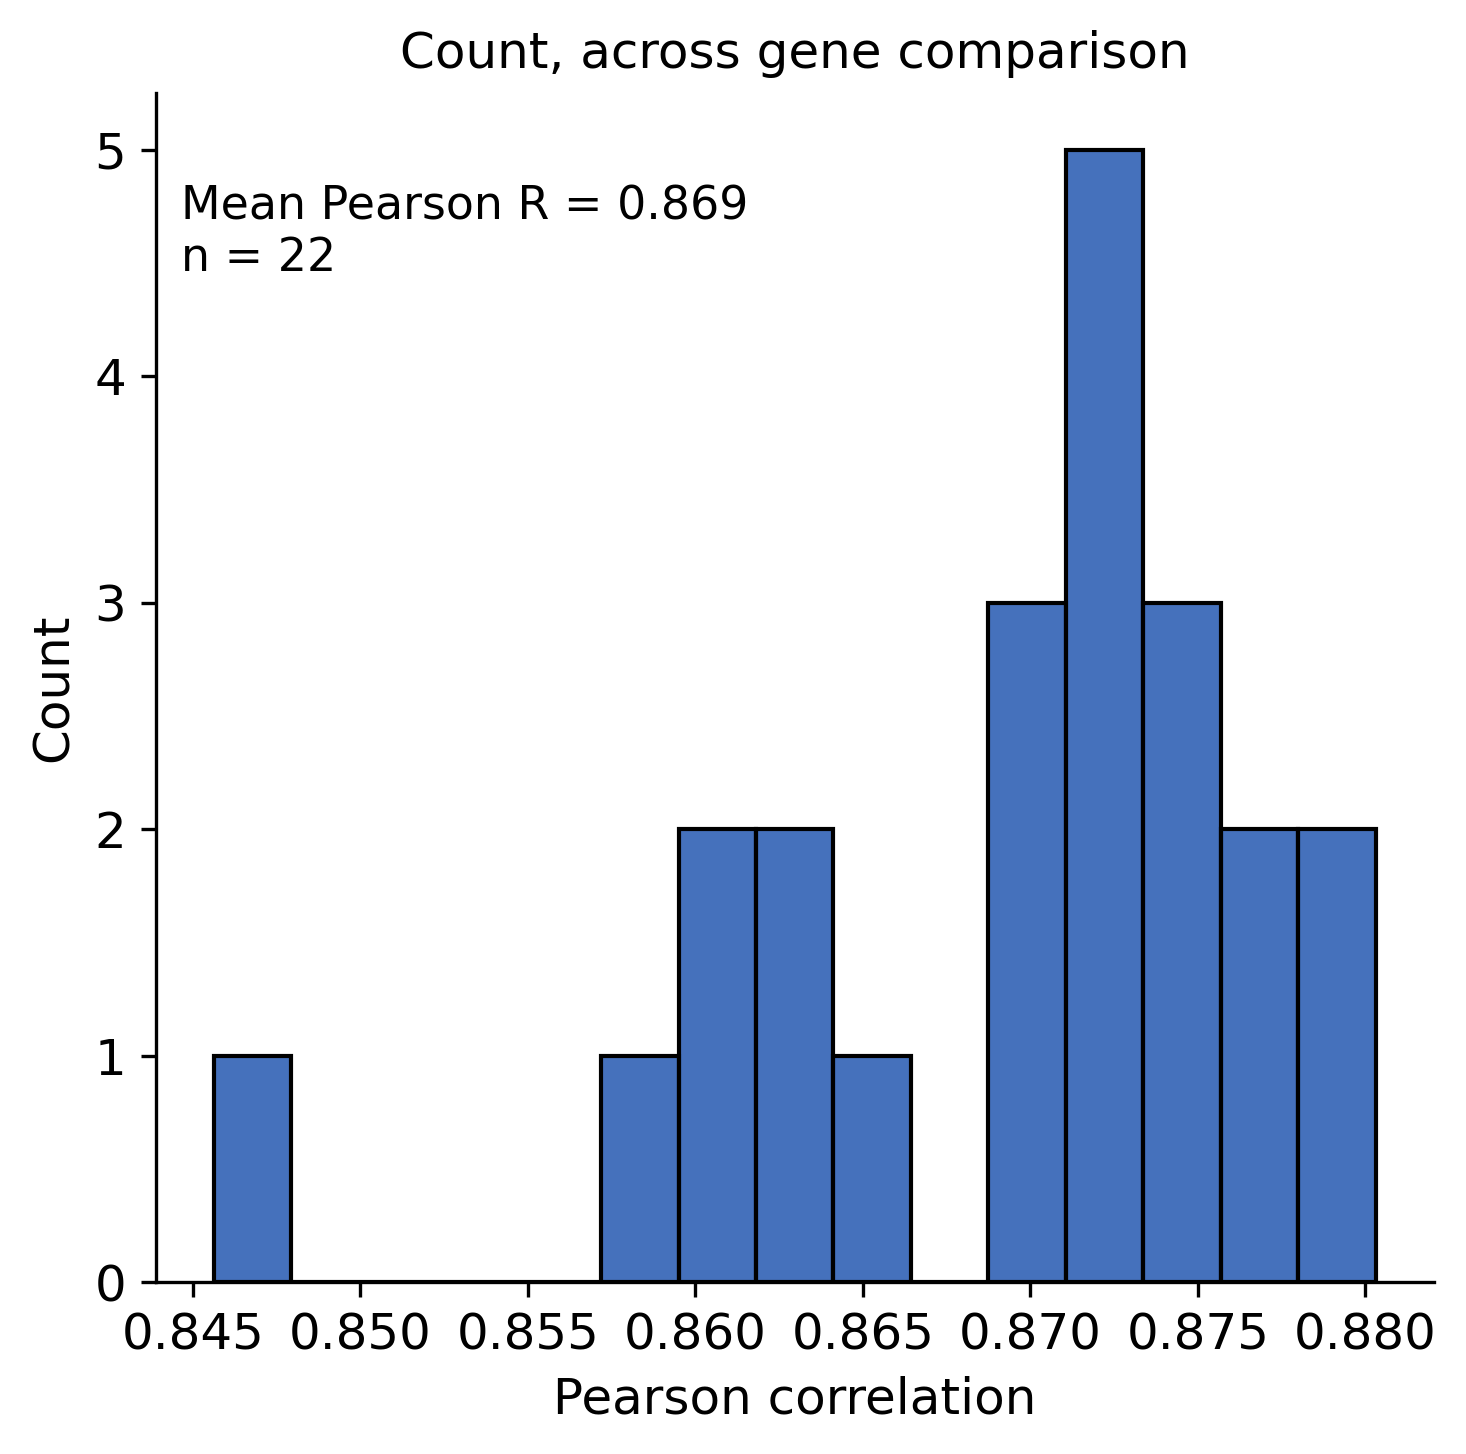

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.histplot(pearsonr, bins = 15, color='#0742A6')
ax.set_xlabel('Pearson correlation')
ax.set_title('Count, across gene comparison')
ax.text(0.02,.85, "Mean " + r"Pearson R"+ f" = {np.mean(pearsonr):.3f} \nn = {len(pearsonr)}", 
        fontdict={'size' : 11},
       transform = ax.transAxes)
plt.tight_layout()
sns.despine()
fig.set_dpi(300)
fig.savefig('../../figures/EDFigures/across_gene_histogram_onek1k.svg')

In [32]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log =np.log2(pd.DataFrame(all_targets) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

/scratch/tmp/martensl/ipykernel_1286478/2719401023.py:20: UserWarning: Adding colorbar to a different Figure <Figure size 1500x1500 with 1 Axes> than <Figure size 1500x1500 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(g, ax=ax)


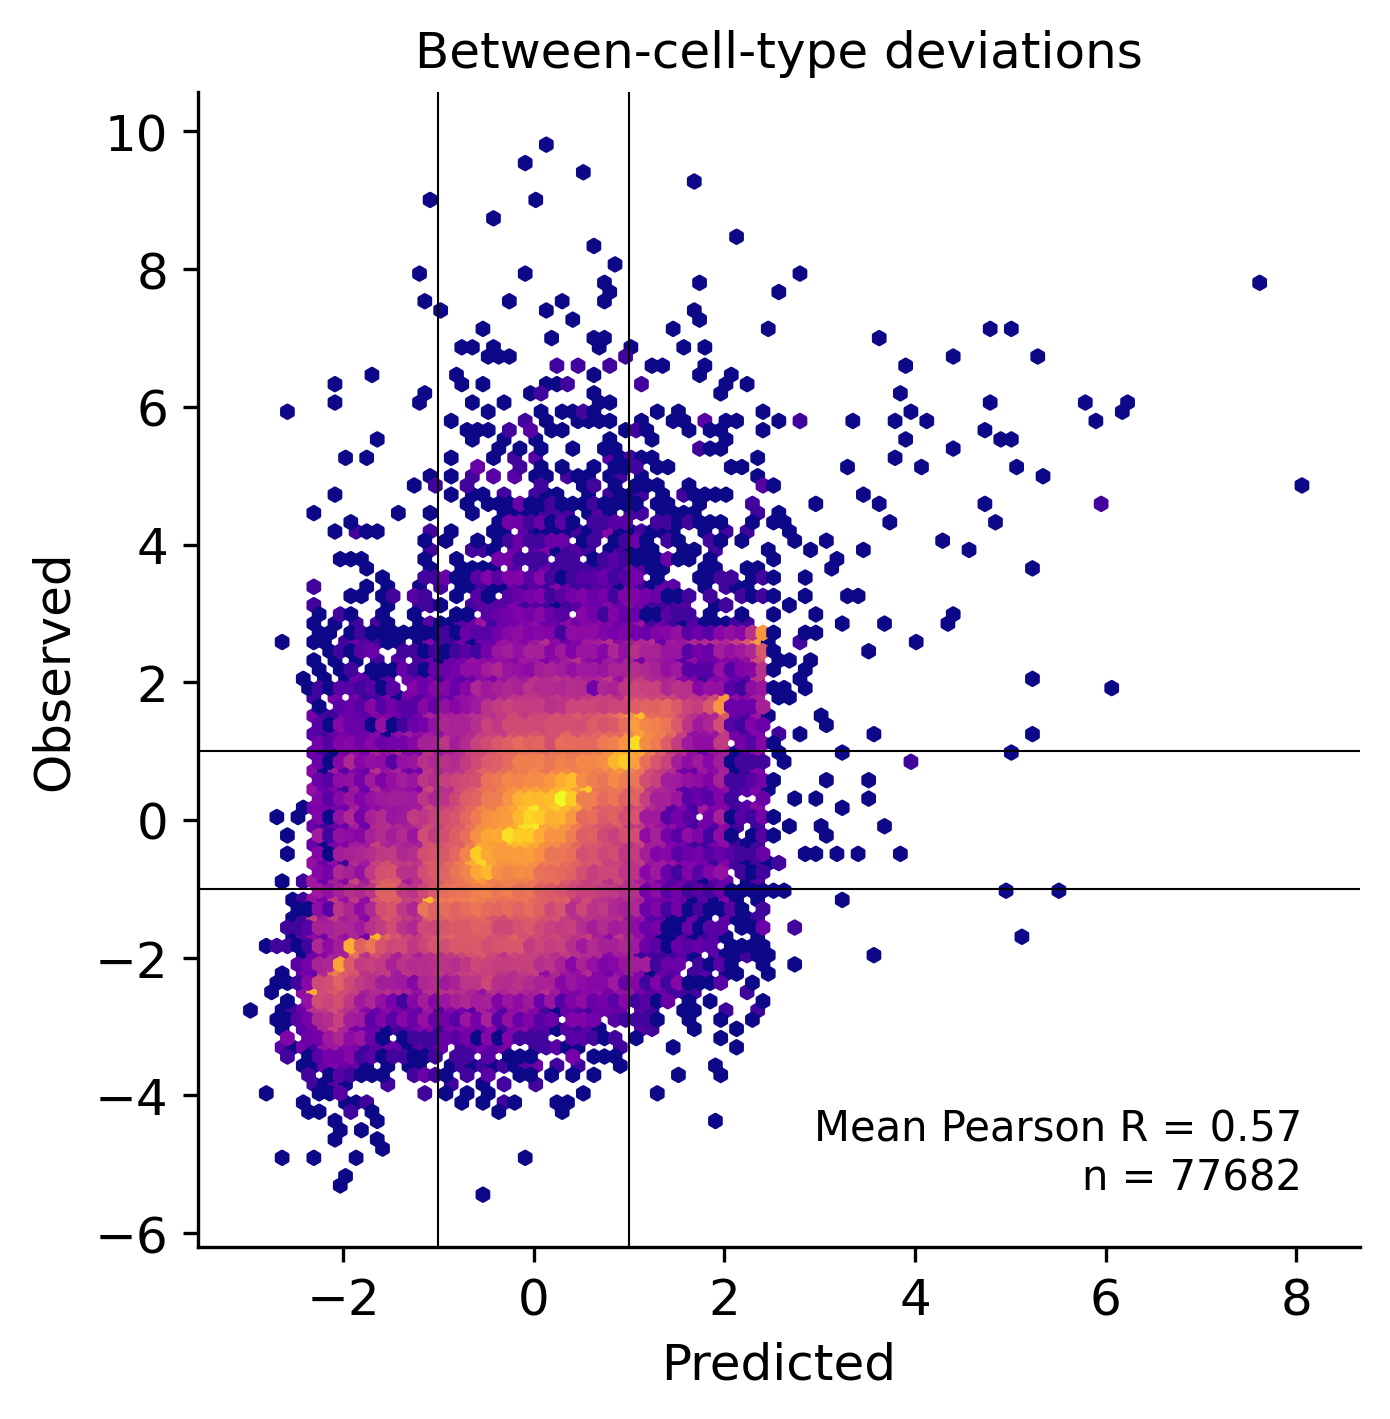

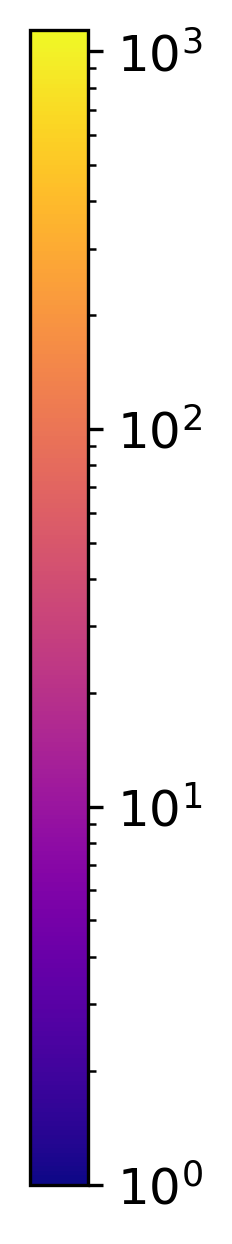

In [34]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
g=ax.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
ax.axvline(1, c='k', linewidth = font_size/24)
ax.axvline(-1,c='k', linewidth = font_size/24)
ax.axhline(1,c='k', linewidth = font_size/24)
ax.axhline(-1,c='k', linewidth = font_size/24)


p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
plt.text(0.95,0.05, "Mean " + r"Pearson R"+ f" = {p:.2f}\nn = {len(counts_predicted_log.values.ravel())}", fontdict={'size' : 10}, transform=ax.transAxes, ha='right')

ax.set_ylabel('Observed')
ax.set_title('Between-cell-type deviations')
ax.set_xlabel('Predicted')
sns.despine()
fig.savefig('../../figures/EDFigures/across_cells_onek1k.svg')

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
fig.colorbar(g, ax=ax)
fig.axes[0].remove()
fig.savefig('../../figures/EDFigures/across_cells_colorbar_onek1k.svg')